## SQL Notebook for Current Year Database

In [34]:
## Dependencies
import os
import sys
import time

import numpy as np
import pandas as pd
import sqlite3

# Database Path
db_path = os.path.join('..', 'data', 'db', '2021_Full_Stats.db')

### Set the season for the file tag
season = '2021'

# db_path = '../data/db/CHN_YTD_Stats.db'

# Connect to the database
conn = sqlite3.connect(db_path)

# Print table names
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

tables = cursor.fetchall()
for table in tables:
    print(table[0])
# 


goalie_stats
line_chart
advanced_metrics
game_details
player_stats
linescore
penalty_summary
scoring_summary
player_stats_ytd
master_roster


# Calculate Empty Net Time for and against for each team

## CHN Stats count goalies pulled during delayed penalties as empty nets
### haven't figured out a way to differentiate between times teams pulled goalies at end of game to make up a deff 

In [35]:
from datetime import timedelta
import pandas as pd

# Load the goalie stats table
goalie_stats = pd.read_sql_query("SELECT * FROM goalie_stats", conn)

goalie_stats.head()


,Team,Goalie,SV,GA,Minutes,Game_ID
0,Army,Justin Evenson,33,7,60:00,2021-10-02-Army-Providence
1,Providence,Jimmy Scannell,1,0,3:09,2021-10-02-Army-Providence
2,Providence,Jaxson Stauber,24,0,56:51,2021-10-02-Army-Providence
3,Sacred Heart,EMPTY NET,0,2,0:45,2021-10-02-Sacred Heart-Connecticut
4,Sacred Heart,Josh Benson,22,4,59:15,2021-10-02-Sacred Heart-Connecticut


In [36]:
from datetime import timedelta
import pandas as pd

# Load the goalie stats table
goalie_stats = pd.read_sql_query("SELECT * FROM goalie_stats", conn)



# Convert "Minutes" to total minutes as a float
def convert_minutes_to_numeric(minutes_str):
    try:
        mins, secs = map(int, minutes_str.split(":"))
        return mins + secs / 60.0  # Convert seconds to a fraction of a minute
    except ValueError:
        return 0.0

goalie_stats['Total_Minutes'] = goalie_stats['Minutes'].apply(convert_minutes_to_numeric)

# Identify games with an EMPTY NET and involved teams
empty_net_games_info = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET'][['Game_ID', 'Team', 'Total_Minutes']]

# Merge to find opposing teams in those games
opposing_teams_info = goalie_stats.drop_duplicates(subset='Game_ID').merge(empty_net_games_info, on='Game_ID', suffixes=('_opp', '_empty'))
opposing_teams_info = opposing_teams_info[opposing_teams_info['Team_opp'] != opposing_teams_info['Team_empty']]

# Aggregate Instances_Faced from opposing_teams_info
instances_faced_corrected = opposing_teams_info.groupby('Team_empty').size().reset_index(name='Instances_Faced').rename(columns={'Team_empty': 'Team'})

# Aggregate original team pulling EMPTY NET stats
teams_pulling_empty_net_aggregated = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET'].groupby('Team').agg(
    Instances_Pulled=('Game_ID', 'nunique'),
    Total_Time_Pulled=('Total_Minutes', 'sum')
).reset_index()

# Aggregate total time faced by team
total_time_faced_by_team_corrected = empty_net_games_info.merge(goalie_stats[['Game_ID', 'Team']], 
                                                                left_on='Game_ID', 
                                                                right_on='Game_ID', 
                                                                suffixes=('_empty', '_facing'))

# Ensure we're using the 'Team_facing' column for grouping, which represents the teams facing an EMPTY NET
total_time_faced_corrected = total_time_faced_by_team_corrected.groupby('Team_facing')['Total_Minutes'].sum().reset_index().rename(columns={'Team_facing': 'Team', 'Total_Minutes': 'Total_Time_Faced_Corrected'})

# Change Total_Time_Faced_Corrected to minutes 
total_time_faced_corrected['Total_Time_Faced_Corrected'] = total_time_faced_corrected['Total_Time_Faced_Corrected'] / 60

# Merge Instances_Faced with total time faced corrected data
final_aggregation_with_instances_and_faced = pd.merge(total_time_faced_corrected, 
                                                      instances_faced_corrected, 
                                                      on='Team', 
                                                      how='outer').fillna(0)

# Merge this combined data with the pulling stats for the final aggregation
final_aggregation_finalized = pd.merge(teams_pulling_empty_net_aggregated, 
                                       final_aggregation_with_instances_and_faced, 
                                       on='Team', 
                                       how='outer').fillna(0)

print(final_aggregation_finalized.head())

             Team  Instances_Pulled  Total_Time_Pulled  \
0       Air Force                11          23.183333   
1          Alaska                18          21.050000   
2  American Int'l                20          23.650000   
3   Arizona State                19          19.400000   
4            Army                16          15.633333   

   Total_Time_Faced_Corrected  Instances_Faced  
0                    1.223611                5  
1                    1.095833                8  
2                    1.577500               10  
3                    1.071389                4  
4                    0.993056                6  


In [37]:
from datetime import timedelta

# Load the goalie stats table
goalie_stats = pd.read_sql_query("SELECT * FROM goalie_stats", conn)

# Adjust the application of the conversion to ensure accuracy
# Instead of converting to timedelta objects, directly convert to total minutes as a float
def convert_minutes_to_numeric(minutes_str):
    try:
        mins, secs = map(int, minutes_str.split(":"))
        return mins + secs / 60.0  # Convert seconds to a fraction of a minute
    except ValueError:
        return 0.0  # Return 0 for any parsing errors or invalid formats

# Apply this conversion to the goalie_stats DataFrame
goalie_stats['Total_Minutes'] = goalie_stats['Minutes'].apply(convert_minutes_to_numeric)



# Helper function to convert time strings to timedelta objects
def parse_time(time_str):
    try:
        min, sec = map(int, time_str.split(":"))
        return timedelta(minutes=min, seconds=sec)
    except:
        return timedelta(0)  # Return 0 timedelta for any parsing errors

# Convert Minutes to timedelta for analysis
goalie_stats['TimeDelta'] = goalie_stats['Minutes'].apply(parse_time)

# NEW ATTACK

In [38]:
# # Step 1: Directly identify all games with an EMPTY NET and the involved teams
# empty_net_games_info = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET'][['Game_ID', 'Team']]


# # Step 2: Identify the opposing team for each EMPTY NET instance
# # We'll need to join this information back to the goalie_stats to find the opposing team in each game
# opposing_teams_info = goalie_stats.drop_duplicates(subset='Game_ID').merge(empty_net_games_info, on='Game_ID', suffixes=('_opp', '_empty'))
# opposing_teams_info = opposing_teams_info[opposing_teams_info['Team_opp'] != opposing_teams_info['Team_empty']]

# # Step 3: Aggregate this information to count the instances faced and calculate total time faced
# # Calculate total time faced by summing durations for each team when they faced an EMPTY NET
# # Adjusting the approach to ensure all variables and data used are correctly defined and relevant

# # Re-aggregating the original team pulling EMPTY NET stats for clarity and to avoid the previous reference error
# teams_pulling_empty_net_aggregated = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET'].groupby('Team').agg(
#     Instances_Pulled=('Game_ID', 'nunique'),
#     Total_Time_Pulled=('TimeDelta', 'sum')
# ).reset_index()
# teams_pulling_empty_net_aggregated['Total_Time_Pulled'] = teams_pulling_empty_net_aggregated['Total_Time_Pulled'].dt.total_seconds() / 60

# # Adjusting the column references for accurate aggregation

# # Ensuring the column name matches for the aggregation process
# total_time_faced_corrected = total_time_faced_by_team_corrected.groupby('Team_x')['Total_Minutes'].sum().reset_index().rename(columns={'Team_x': 'Team', 'Total_Minutes': 'Total_Time_Faced_Corrected'})
# # COnvert Total_Time_Faced_Corrected to minutes
# total_time_faced_corrected['Total_Time_Faced_Corrected'] = total_time_faced_corrected['Total_Time_Faced_Corrected'] / 60
# # Calculate the instances the opponent pulled the goalie
# opposing_teams_info = opposing_teams_info.groupby('Team_opp').size().reset_index(name='Instances_Faced')


# # Recalculating Instances_Faced from opposing_teams_info correctly before merging

# # Ensuring the Instances_Faced calculation is applied correctly
# instances_faced_corrected = opposing_teams_info.groupby('Team_empty').size().reset_index(name='Instances_Faced').rename(columns={'Team_empty': 'Team'})

# # Merging Instances_Faced with the total time faced corrected data
# final_aggregation_with_instances_and_faced = pd.merge(total_time_faced_corrected, 
#                                                       instances_faced_corrected, 
#                                                       on='Team', 
#                                                       how='outer').fillna(0)

# # Merging this combined data with the pulling stats for the final aggregation
# final_aggregation_finalized = pd.merge(teams_pulling_empty_net_aggregated, 
#                                        final_aggregation_with_instances_and_faced, 
#                                        on='Team', 
#                                        how='outer').fillna(0)

# final_aggregation_finalized.head()


In [39]:
# # Ensuring both Total_Time_Pulled and Total_Time_Faced_Corrected are in minutes for accurate comparison

# # Correcting Total_Time_Faced_Corrected to ensure it's represented in minutes
# # The previous aggregation likely already calculated Total_Minutes correctly, so we should adjust the representation to match that understanding
# final_aggregation_corrected_time['Total_Time_Faced_Corrected'] = final_aggregation_corrected_time['Total_Time_Faced_Corrected'] / 60  # Converting to minutes if it was mistakenly treated as seconds

# final_aggregation_corrected_time.head()


# Previous Approach

In [40]:
from datetime import timedelta

# Helper function to convert time strings to timedelta objects
def parse_time(time_str):
    try:
        min, sec = map(int, time_str.split(":"))
        return timedelta(minutes=min, seconds=sec)
    except:
        return timedelta(0)  # Return 0 timedelta for any parsing errors

# Convert Minutes to timedelta for analysis
goalie_stats['TimeDelta'] = goalie_stats['Minutes'].apply(parse_time)

# Calculate the percentage of games with at least one EMPTY NET
games_with_empty_net = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET']['Game_ID'].nunique()
total_games = goalie_stats['Game_ID'].nunique()
percentage_empty_net = (games_with_empty_net / total_games) * 100

# Calculate the number of games where both teams had an EMPTY NET
games_both_teams_empty_net = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET'].groupby('Game_ID').filter(lambda x: len(x) > 1)['Game_ID'].nunique()

# Basic statistics about the length of time EMPTY NET appears in games
empty_net_times = goalie_stats[goalie_stats['Goalie'] == 'EMPTY NET']['TimeDelta']
min_empty_net = empty_net_times.min().total_seconds() / 60
max_empty_net = empty_net_times.max().total_seconds() / 60
mean_empty_net = empty_net_times.mean().total_seconds() / 60
median_empty_net = empty_net_times.median().total_seconds() / 60
std_empty_net = empty_net_times.std().total_seconds() / 60

percentage_empty_net, games_both_teams_empty_net, min_empty_net, max_empty_net, mean_empty_net, median_empty_net, std_empty_net


(80.60941828254848,
 220,
 0.016666666666666666,
 52.583333333333336,
 1.1449832166666667,
 0.8,
 1.8832913166666667)

## Plot distribution of EMPTY NET instances
- GOAL find a value to use to filter very short instances out to try to eliminate delayed penalty empty nets vs end of game empty nets

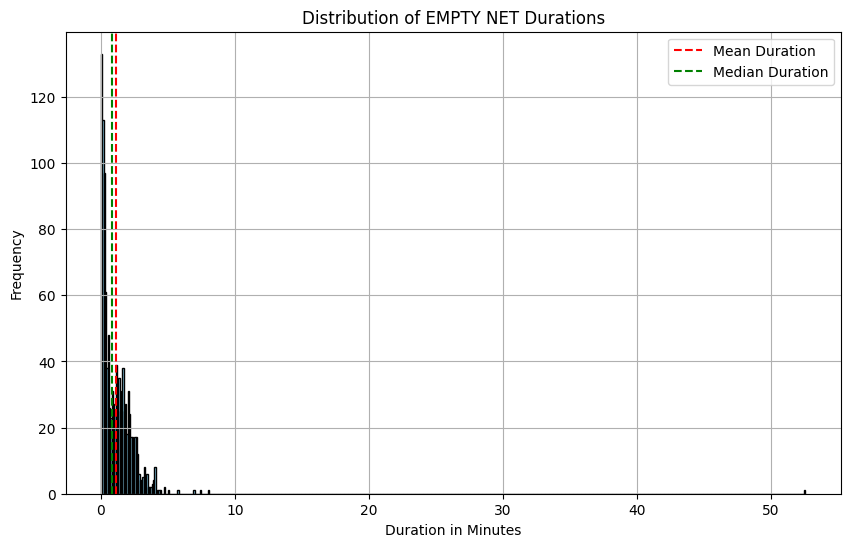

(array([0.03333333, 0.07      , 0.21666667, 0.8       , 1.73333333,
        2.53333333, 3.10666667]),
 [5, 10, 25, 50, 75, 90, 95])

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the distribution of EMPTY NET durations
plt.figure(figsize=(10, 6))
plt.hist(empty_net_times.dt.total_seconds() / 60, bins=np.arange(0, max_empty_net + 0.1, 0.1), color='skyblue', edgecolor='black')
plt.title('Distribution of EMPTY NET Durations')
plt.xlabel('Duration in Minutes')
plt.ylabel('Frequency')
plt.axvline(x=mean_empty_net, color='red', linestyle='--', label='Mean Duration')
plt.axvline(x=median_empty_net, color='green', linestyle='--', label='Median Duration')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and display the percentiles for further insight
percentiles = [5, 10, 25, 50, 75, 90, 95]
percentile_values = np.percentile(empty_net_times.dt.total_seconds() / 60, percentiles)

percentile_values, percentiles


In [42]:
# Filter out EMPTY NET instances shorter than the 25th percentile cutoff (0.18 minutes)
filtered_goalie_stats = goalie_stats[(goalie_stats['Goalie'] != 'EMPTY NET') | (goalie_stats['TimeDelta'] >= timedelta(minutes=0.18))]

# Recalculate the percentage of games with at least one EMPTY NET after filtering
games_with_empty_net_filtered = filtered_goalie_stats[filtered_goalie_stats['Goalie'] == 'EMPTY NET']['Game_ID'].nunique()
percentage_empty_net_filtered = (games_with_empty_net_filtered / total_games) * 100

# Recalculate the number of games where both teams had an EMPTY NET after filtering
games_both_teams_empty_net_filtered = filtered_goalie_stats[filtered_goalie_stats['Goalie'] == 'EMPTY NET'].groupby('Game_ID').filter(lambda x: len(x) > 1)['Game_ID'].nunique()

# Recalculate basic statistics about the length of time EMPTY NET appears in games after filtering
empty_net_times_filtered = filtered_goalie_stats[filtered_goalie_stats['Goalie'] == 'EMPTY NET']['TimeDelta']
min_empty_net_filtered = empty_net_times_filtered.min().total_seconds() / 60
max_empty_net_filtered = empty_net_times_filtered.max().total_seconds() / 60
mean_empty_net_filtered = empty_net_times_filtered.mean().total_seconds() / 60
median_empty_net_filtered = empty_net_times_filtered.median().total_seconds() / 60
std_empty_net_filtered = empty_net_times_filtered.std().total_seconds() / 60

(percentage_empty_net_filtered, games_both_teams_empty_net_filtered, min_empty_net_filtered, max_empty_net_filtered, mean_empty_net_filtered, median_empty_net_filtered, std_empty_net_filtered)


(71.09879963065559,
 98,
 0.18333333333333332,
 52.583333333333336,
 1.4207949166666665,
 1.2,
 2.0240408833333334)

## Aggrigate and tally the time with and againsts empty net

In [43]:
# OUTPUT to csv 
# filtered_goalie_stats
# filtered_goalie_stats.to_csv('filtered_goalie_stats.csv', index=False)

filtered_goalie_stats.head()
## HOTFIX FOR NAME MATCHING ERROR
# Replace any '-' in Team with ' '
filtered_goalie_stats['Team'] = filtered_goalie_stats['Team'].str.replace('-', ' ')

# home team is after 4th - in Game_ID
# away team is 3rd before 4th - in Game_ID
# Create new columns
filtered_goalie_stats['Home_Team'] = filtered_goalie_stats['Game_ID'].str.split('-').str[-1]
filtered_goalie_stats['Away_Team'] = filtered_goalie_stats['Game_ID'].str.split('-').str[-2]

# Drop any games that do not have an EMPTY NET instance
filtered_goalie_stats = filtered_goalie_stats[filtered_goalie_stats['Game_ID'].isin(filtered_goalie_stats[filtered_goalie_stats['Goalie'] == 'EMPTY NET']['Game_ID'].unique())]

# filtered_goalie_stats.head(10)
# OUTPUT to csv 
# filtered_goalie_stats
filtered_goalie_stats.to_csv('filtered_goalie_stats.csv', index=False)

C:\Users\jbanc\AppData\Local\Temp\ipykernel_7948\3686376507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_goalie_stats['Team'] = filtered_goalie_stats['Team'].str.replace('-', ' ')
C:\Users\jbanc\AppData\Local\Temp\ipykernel_7948\3686376507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_goalie_stats['Home_Team'] = filtered_goalie_stats['Game_ID'].str.split('-').str[-1]
C:\Users\jbanc\AppData\Local\Temp\ipykernel_7948\3686376507.py:14: SettingWithCopyWarning: 
A value is trying 

# SEEMS TO BE WORKING HERE WITH THIS METHOD - 

In [44]:
updated_filtered_goalie_stats = filtered_goalie_stats

# Convert "Minutes" to total minutes as a float for consistency
updated_filtered_goalie_stats['Total_Minutes'] = updated_filtered_goalie_stats['Minutes'].apply(convert_minutes_to_numeric)

# Aggregate the times each team pulled their goalie
teams_pulled_goalie_agg = updated_filtered_goalie_stats[updated_filtered_goalie_stats['Goalie'] == 'EMPTY NET'].groupby('Team').agg(
    Instances_Pulled=('Game_ID', 'count'),
    Total_Time_Pulled=('Total_Minutes', 'sum')
).reset_index()

# For calculating the instances and time faced, we need to determine when the team is not the one with the EMPTY NET
# This involves checking against Home_Team and Away_Team to assign the correct opposing team

# Mark rows where the goalie was pulled (EMPTY NET) to help with opponent calculations
updated_filtered_goalie_stats['Goalie_Pulled'] = updated_filtered_goalie_stats['Goalie'] == 'EMPTY NET'

# Calculate instances and total time faced for each team
def calculate_faced_stats(row):
    if row['Goalie_Pulled']:
        if row['Team'] == row['Home_Team']:
            return row['Away_Team']
        else:
            return row['Home_Team']
    return None

updated_filtered_goalie_stats['Opponent_When_Pulled'] = updated_filtered_goalie_stats.apply(calculate_faced_stats, axis=1)

# Aggregate for opponents faced an EMPTY NET
opponents_faced_agg = updated_filtered_goalie_stats.dropna(subset=['Opponent_When_Pulled']).groupby('Opponent_When_Pulled').agg(
    Instances_Faced=('Game_ID', 'count'),
    Total_Time_Faced=('Total_Minutes', 'sum')
).reset_index().rename(columns={'Opponent_When_Pulled': 'Team'})

# Merge the pulling and facing stats into a single DataFrame
final_aggregated_stats = pd.merge(teams_pulled_goalie_agg, opponents_faced_agg, on='Team', how='outer').fillna(0)

final_aggregated_stats.head()


,Team,Instances_Pulled,Total_Time_Pulled,Instances_Faced,Total_Time_Faced
0,Air Force,11,23.183333,12,14.750000
1,Alaska,15,20.900000,13,16.716667
2,American Int'l,13,22.916667,16,26.333333
3,Arizona State,15,19.066667,14,19.933333
4,Army,13,15.550000,11,25.916667


# Team Empty Net and Extra Attacker Goals

In [45]:
import pandas as pd

# Load the dataset
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM scoring_summary;", conn)



# Ensure 'PP' column is treated as a string, converting NaN values to empty strings for easier processing
df['PP'] = df['PP'].fillna('')

# Initialize columns for EN and EA goals scored and given up
df['EN_scored'] = df['PP'].apply(lambda x: 'EN' in x).astype(int)
df['EA_scored'] = df['PP'].apply(lambda x: 'EA' in x).astype(int)

# Create a mapping of teams to goals given up
goals_given_up = {team: {'EN_given_up': 0, 'EA_given_up': 0} for team in df['Team'].unique()}

# Iterate over the rows to update the goals given up
for index, row in df.iterrows():
    conceding_team = row['Away_Team'] if row['Team'] == row['Home_Team'] else row['Home_Team']
    if 'EN' in row['PP']:
        goals_given_up[conceding_team]['EN_given_up'] += 1
    if 'EA' in row['PP']:
        goals_given_up[conceding_team]['EA_given_up'] += 1

# Convert the mapping to a DataFrame
goals_given_up_df = pd.DataFrame.from_dict(goals_given_up, orient='index').reset_index()
goals_given_up_df.rename(columns={'index': 'Team'}, inplace=True)

# Merge the scored goals with the given up goals
result_df = df.groupby('Team').agg({'EN_scored': 'sum', 'EA_scored': 'sum'}).reset_index()
result = pd.merge(result_df, goals_given_up_df, on='Team')

print(result)


                 Team  EN_scored  EA_scored  EN_given_up  EA_given_up
0           Air Force          2          3            1            3
1              Alaska          5          1            7            2
2      American Int'l          8          4            2            2
3       Arizona State          8          3            8            4
4                Army          7          1            6            0
5       Bemidji State          7          4            5            4
6             Bentley          2          1            6            3
7      Boston College          4          3            8            0
8   Boston University          7          1            4            0
9       Bowling Green          4          1            8            1
10              Brown          2          2            6            2
11           Canisius          7          1           10            4
12           Clarkson          4          7            6            3
13            Colgat

In [46]:
# 3 sort by EN scored
result = result.sort_values(by='EN_scored', ascending=False)

# Calculate the EN Goals Scored to EA Goals Given Up Ration
result['EN_vs_EA_Ratio'] = result['EN_scored'] / result['EA_given_up']

# calulate EA Goals Scored to EN Goals Given Up Ratio
result['EA_vs_EN_Ratio'] = result['EA_scored'] / result['EN_given_up']

result.head(20)



,Team,EN_scored,EA_scored,EN_given_up,EA_given_up,EN_vs_EA_Ratio,EA_vs_EN_Ratio
49,Rensselaer,12,3,7,6,2.000000,0.428571
56,Western Michigan,11,0,2,1,11.000000,0.000000
22,Lake Superior,10,3,5,0,inf,0.600000
47,Quinnipiac,10,3,3,1,10.000000,1.000000
40,Northern Michigan,10,2,6,5,2.000000,0.333333
20,Harvard,9,5,4,4,2.250000,1.250000
33,Minnesota,8,4,1,1,8.000000,4.000000
3,Arizona State,8,3,8,4,2.000000,0.375000
30,Michigan,8,0,2,2,4.000000,0.000000
2,American Int'l,8,4,2,2,4.000000,2.000000


In [47]:
## Merge the result with the final_aggregated_stats
final_result = pd.merge(result, final_aggregated_stats, on='Team', how='outer').fillna(0)

final_result.head(20)

,Team,EN_scored,EA_scored,EN_given_up,EA_given_up,EN_vs_EA_Ratio,EA_vs_EN_Ratio,Instances_Pulled,Total_Time_Pulled,Instances_Faced,Total_Time_Faced
0,Rensselaer,12,3,7,6,2.000000,0.428571,16,26.300000,17,33.466667
1,Western Michigan,11,0,2,1,11.000000,0.000000,10,13.366667,17,19.666667
2,Lake Superior,10,3,5,0,inf,0.600000,14,17.000000,13,18.616667
3,Quinnipiac,10,3,3,1,10.000000,1.000000,14,18.683333,18,28.316667
4,Northern Michigan,10,2,6,5,2.000000,0.333333,13,16.350000,19,25.283333
5,Harvard,9,5,4,4,2.250000,1.250000,14,19.966667,19,23.516667
6,Minnesota,8,4,1,1,8.000000,4.000000,15,20.100000,17,18.716667
7,Arizona State,8,3,8,4,2.000000,0.375000,15,19.066667,14,19.933333
8,Michigan,8,0,2,2,4.000000,0.000000,12,8.433333,15,22.283333
9,American Int'l,8,4,2,2,4.000000,2.000000,13,22.916667,16,26.333333


In [48]:
# Rearange the columns for better readability
final_result = final_result[['Team', 'Instances_Pulled', 'EA_scored', 'EN_given_up',  'Total_Time_Pulled', 
                             'Instances_Faced', 'EN_scored',  'EA_given_up', 'Total_Time_Faced',
                             'EN_vs_EA_Ratio', 
                             'EA_vs_EN_Ratio']]

# Calculate some rates
final_result['EN_Goals_Scored_Per_Minute'] = final_result['EN_scored'] / final_result['Total_Time_Faced']
# Allowed EN Goals Per Minute
final_result['EN_Goals_Allowed_Per_Minute'] = final_result['EN_given_up'] / final_result['Total_Time_Pulled']
## EA Goals Scored Per Minute
final_result['EA_Goals_Scored_Per_Minute'] = final_result['EA_scored'] / final_result['Total_Time_Pulled']
## EA Goals Allowed Per Minute
final_result['EA_Goals_Allowed_Per_Minute'] = final_result['EA_given_up'] / final_result['Total_Time_Faced']


## Inverse Calculation - amount of time it takes to score a goal / give up a goal in those situations
final_result['Minutes_Per_EN_Goals_Scored'] = final_result['Total_Time_Faced'] / final_result['EN_scored']
final_result['Minutes_Per_EN_Goals_Given_Up'] = final_result['Total_Time_Pulled'] / final_result['EN_given_up']
final_result['Minutes_Per_EA_Goals_Scored'] = final_result['Total_Time_Pulled'] / final_result['EA_scored']
final_result['Minutes_Per_EA_Goals_Given_Up'] = final_result['Total_Time_Faced'] / final_result['EA_given_up']

final_result['Goal/Min EN_vs_EA_Ratio'] = final_result['EN_Goals_Scored_Per_Minute'] / final_result['EA_Goals_Allowed_Per_Minute']
final_result['Goal/Min EA_vs_EN_Ratio'] = final_result['EA_Goals_Scored_Per_Minute'] / final_result['EN_Goals_Allowed_Per_Minute']

# Rename the columns for better readability
final_result['EN_vs_EA_Count_Ratio'] = final_result['EN_vs_EA_Ratio']
final_result['EA_vs_EN_Count_Ratio'] = final_result['EA_vs_EN_Ratio']

# Rearange the columns for better readability
final_result = final_result[['Team', 'Instances_Pulled', 'EA_scored', 'EA_Goals_Scored_Per_Minute', 'Minutes_Per_EA_Goals_Scored',
                             'EN_given_up',  'EN_Goals_Allowed_Per_Minute', 'Minutes_Per_EN_Goals_Given_Up', 'Total_Time_Pulled', 
                             
                             'Instances_Faced', 'EN_scored', 'EN_Goals_Scored_Per_Minute','Minutes_Per_EN_Goals_Scored',
                              'EA_given_up', 'EA_Goals_Allowed_Per_Minute', 'Minutes_Per_EA_Goals_Given_Up', 'Total_Time_Faced',
                              
                              
                              
                              'EN_vs_EA_Count_Ratio', 
                             'EA_vs_EN_Count_Ratio',
                             ]]

final_result.head(20)

,Team,Instances_Pulled,EA_scored,EA_Goals_Scored_Per_Minute,Minutes_Per_EA_Goals_Scored,EN_given_up,EN_Goals_Allowed_Per_Minute,Minutes_Per_EN_Goals_Given_Up,Total_Time_Pulled,Instances_Faced,EN_scored,EN_Goals_Scored_Per_Minute,Minutes_Per_EN_Goals_Scored,EA_given_up,EA_Goals_Allowed_Per_Minute,Minutes_Per_EA_Goals_Given_Up,Total_Time_Faced,EN_vs_EA_Count_Ratio,EA_vs_EN_Count_Ratio
0,Rensselaer,16,3,0.114068,8.766667,7,0.266160,3.757143,26.300000,17,12,0.358566,2.788889,6,0.179283,5.577778,33.466667,2.000000,0.428571
1,Western Michigan,10,0,0.000000,inf,2,0.149626,6.683333,13.366667,17,11,0.559322,1.787879,1,0.050847,19.666667,19.666667,11.000000,0.000000
2,Lake Superior,14,3,0.176471,5.666667,5,0.294118,3.400000,17.000000,13,10,0.537153,1.861667,0,0.000000,inf,18.616667,inf,0.600000
3,Quinnipiac,14,3,0.160571,6.227778,3,0.160571,6.227778,18.683333,18,10,0.353149,2.831667,1,0.035315,28.316667,28.316667,10.000000,1.000000
4,Northern Michigan,13,2,0.122324,8.175000,6,0.366972,2.725000,16.350000,19,10,0.395517,2.528333,5,0.197759,5.056667,25.283333,2.000000,0.333333
5,Harvard,14,5,0.250417,3.993333,4,0.200334,4.991667,19.966667,19,9,0.382707,2.612963,4,0.170092,5.879167,23.516667,2.250000,1.250000
6,Minnesota,15,4,0.199005,5.025000,1,0.049751,20.100000,20.100000,17,8,0.427427,2.339583,1,0.053428,18.716667,18.716667,8.000000,4.000000
7,Arizona State,15,3,0.157343,6.355556,8,0.419580,2.383333,19.066667,14,8,0.401338,2.491667,4,0.200669,4.983333,19.933333,2.000000,0.375000
8,Michigan,12,0,0.000000,inf,2,0.237154,4.216667,8.433333,15,8,0.359013,2.785417,2,0.089753,11.141667,22.283333,4.000000,0.000000
9,American Int'l,13,4,0.174545,5.729167,2,0.087273,11.458333,22.916667,16,8,0.303797,3.291667,2,0.075949,13.166667,26.333333,4.000000,2.000000


In [49]:
# OUTPUT to csv
final_result.to_csv(f'../TEMP/EMP_NET_ANALYSIS_{season}.csv', index=False)

In [50]:
## Sort by Minutes_Per_EA_Goals_Scored
final_result = final_result.sort_values(by='Minutes_Per_EA_Goals_Scored', ascending=True)

# Soft by Minutes per EA Goals Allowed
final_result = final_result.sort_values(by='Minutes_Per_EN_Goals_Given_Up', ascending=True)

final_result.head(20)

,Team,Instances_Pulled,EA_scored,EA_Goals_Scored_Per_Minute,Minutes_Per_EA_Goals_Scored,EN_given_up,EN_Goals_Allowed_Per_Minute,Minutes_Per_EN_Goals_Given_Up,Total_Time_Pulled,Instances_Faced,EN_scored,EN_Goals_Scored_Per_Minute,Minutes_Per_EN_Goals_Scored,EA_given_up,EA_Goals_Allowed_Per_Minute,Minutes_Per_EA_Goals_Given_Up,Total_Time_Faced,EN_vs_EA_Count_Ratio,EA_vs_EN_Count_Ratio
18,Canisius,13,1,0.062241,16.066667,10,0.622407,1.606667,16.066667,16,7,0.243761,4.102381,4,0.139292,7.179167,28.716667,1.750000,0.100000
40,Union,12,1,0.074257,13.466667,8,0.594059,1.683333,13.466667,17,4,0.178971,5.587500,5,0.223714,4.470000,22.350000,0.800000,0.125000
28,Wisconsin,11,1,0.096154,10.400000,6,0.576923,1.733333,10.400000,11,5,0.326087,3.066667,1,0.065217,15.333333,15.333333,5.000000,0.166667
14,Omaha,15,1,0.076628,13.050000,6,0.459770,2.175000,13.050000,19,7,0.255941,3.907143,2,0.073126,13.675000,27.350000,3.500000,0.166667
53,Brown,12,2,0.153061,6.533333,6,0.459184,2.177778,13.066667,15,2,0.127253,7.858333,2,0.127253,7.858333,15.716667,1.000000,0.333333
7,Arizona State,15,3,0.157343,6.355556,8,0.419580,2.383333,19.066667,14,8,0.401338,2.491667,4,0.200669,4.983333,19.933333,2.000000,0.375000
58,St. Thomas,15,2,0.103896,9.625000,8,0.415584,2.406250,19.250000,8,0,0.000000,inf,2,0.380952,2.625000,5.250000,0.000000,0.250000
47,Long Island,9,1,0.097879,10.216667,4,0.391517,2.554167,10.216667,7,3,0.387931,2.577778,1,0.129310,7.733333,7.733333,3.000000,0.250000
17,Army,13,1,0.064309,15.550000,6,0.385852,2.591667,15.550000,11,7,0.270096,3.702381,0,0.000000,inf,25.916667,inf,0.166667
46,Michigan State,15,1,0.076726,13.033333,5,0.383632,2.606667,13.033333,17,3,0.226415,4.416667,1,0.075472,13.250000,13.250000,3.000000,0.200000
